**IMPORT KERAS**

*    Keras is the high-level API of the TensorFlow platform.
*    Keras is a deep learning API written in Python and capable of running on top of either JAX, TensorFlow, or PyTorch.

In [2]:
import keras

**CHECK KERAS VERSION**

In [3]:
keras.__version__

'2.15.0'

**CREATE DATAFRAME WITH PANDAS AND NUMPY**

In [6]:
import numpy as np
import pandas as pd

data=np.array([['young',False, False, 'fair','no'],
               ['young',False,False,'good','no'],
               ['young',True, False, 'good','yes'],
               ['young',True,True,'fair','yes'],
               ['young',False,False,'fair','no'],
               ['middle',False,False,'fair','no'],
               ['middle',False,False,'good','no'],
               ['middle',True,True,'good','yes'],
               ['middle',False,True,'excellent','yes'],
                ['middle',False,True,'excellent','yes'],
                ['old',False,True,'excellent','yes'],
                ['old',False,True,'good','yes'],
                ['old',True,False,'good','yes'],
                ['old',True,False,'excellent','yes'],
                ['old',False,False,'fair','no']])



columns = ['Age','Has_job','Own_house','Credit_rating','Class']

df_dataset = pd.DataFrame(data=data,columns = columns)

df_dataset.head()

,Age,Has_job,Own_house,Credit_rating,Class
0,young,False,False,fair,no
1,young,False,False,good,no
2,young,True,False,good,yes
3,young,True,True,fair,yes
4,young,False,False,fair,no


**SPLIT TRAIN AND TEST DATAS WITH PANDAS**

In [22]:
val_df = df_dataset.sample(frac=0.2, random_state=1337)
train_df = df_dataset.drop(val_df.index)

In [23]:
val_df

,Age,Has_job,Own_house,Credit_rating,Class
5,middle,False,False,fair,no
3,young,True,True,fair,yes
1,young,False,False,good,no


In [24]:
train_df

,Age,Has_job,Own_house,Credit_rating,Class
0,young,False,False,fair,no
2,young,True,False,good,yes
4,young,False,False,fair,no
6,middle,False,False,good,no
7,middle,True,True,good,yes
8,middle,False,True,excellent,yes
9,middle,False,True,excellent,yes
10,old,False,True,excellent,yes
11,old,False,True,good,yes
12,old,True,False,good,yes


**TRANSFORM PANDAS DATAFRAME TO TENSORFLOW DATASET**

In [25]:
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

def dataframe_to_dataset(data):
    dataframe = data.copy()
    labels = data.pop("Class")
    #change class value from true to 1 and false to 0
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

    ds = tf.data.Dataset.from_tensor_slices((dict(data), labels))
    #shuffle dataset
    ds = ds.shuffle(buffer_size=len(data))
    return ds

In [26]:
train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(val_df)

In [28]:
for x,y in train_ds:
  print('Attributes: ',x)
  print('Classes: ',y)

Attributes:  {'Age': <tf.Tensor: shape=(), dtype=string, numpy=b'old'>, 'Has_job': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'Own_house': <tf.Tensor: shape=(), dtype=string, numpy=b'True'>, 'Credit_rating': <tf.Tensor: shape=(), dtype=string, numpy=b'good'>}
Classes:  tf.Tensor(1, shape=(), dtype=int64)
Attributes:  {'Age': <tf.Tensor: shape=(), dtype=string, numpy=b'young'>, 'Has_job': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'Own_house': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'Credit_rating': <tf.Tensor: shape=(), dtype=string, numpy=b'fair'>}
Classes:  tf.Tensor(0, shape=(), dtype=int64)
Attributes:  {'Age': <tf.Tensor: shape=(), dtype=string, numpy=b'middle'>, 'Has_job': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'Own_house': <tf.Tensor: shape=(), dtype=string, numpy=b'False'>, 'Credit_rating': <tf.Tensor: shape=(), dtype=string, numpy=b'good'>}
Classes:  tf.Tensor(0, shape=(), dtype=int64)
Attributes:  {'Age': <tf.Tensor: shape=(), dt

**SPLIT TRAIN AND TEST DATASET TO MINI BATCH**

In [29]:
train_ds = train_ds.batch(4)
val_ds = val_ds.batch(4)

**ENCODING CATEGORICAL FEATURES**

In [32]:
def encode_categorical_feature(feature, name, dataset, is_string):
    lookup_class = keras.layers.StringLookup if is_string else keras.layers.IntegerLookup
    #according to is_string flag, check feature values if is string or integer. If string; return StringLookup,
    #if integer; return IntegerLookup.

    lookup = lookup_class(output_mode="binary")

    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    lookup.adapt(feature_ds)

    encoded_feature = lookup(feature)
    return encoded_feature

**ENCODE ALL FEATURES**

In [33]:

age=keras.Input(shape=(1,),name="Age", dtype="string")
has_job=keras.Input(shape=(1,),name="Has_job",dtype="string")
own_house=keras.Input(shape=(1,),name="Own_house",dtype="string")
credit_rating=keras.Input(shape=(1,),name="Credit_rating", dtype="string")
all_inputs = [age,has_job,own_house,credit_rating]

age_encoded=encode_categorical_feature(age, "Age", train_ds, True)
has_job_encoded=encode_categorical_feature(has_job, "Has_job", train_ds, True)
own_house_encoded=encode_categorical_feature(own_house, "Own_house", train_ds, True)
credit_rating_encoded=encode_categorical_feature(credit_rating, "Credit_rating", train_ds, True)

all_features = keras.layers.concatenate(
    [
        age_encoded,
        has_job_encoded,
        own_house_encoded,
        credit_rating_encoded
    ]
)


**CREATE MODEL WITH KERAS**

In [34]:
x = keras.layers.Dense(32, activation="relu")(all_features)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(8, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
output = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(all_inputs, output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

**PLOT MODEL**

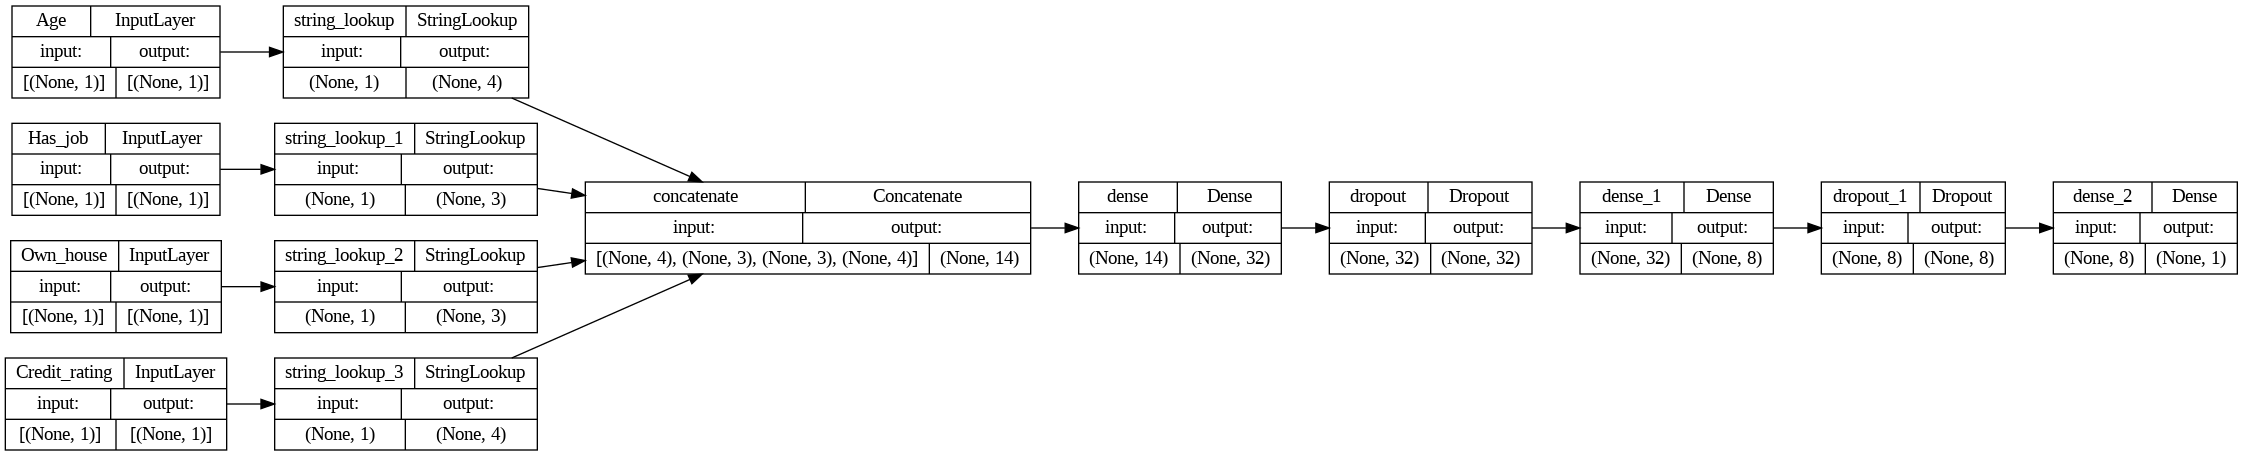

In [35]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True, rankdir="LR")

**MODEL SUMMARY**

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 Has_job (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 Own_house (InputLayer)      [(None, 1)]                  0         []                            
                                                                                                  
 Credit_rating (InputLayer)  [(None, 1)]                  0         []                            
                                                                                              

**TRAIN MODEL**

In [37]:
model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
3/3 [==============================] - 2s 133ms/step - loss: 0.6706 - accuracy: 0.7500 - val_loss: 0.7083 - val_accuracy: 0.6667
Epoch 2/50
3/3 [==============================] - 0s 10ms/step - loss: 0.7887 - accuracy: 0.4167 - val_loss: 0.7045 - val_accuracy: 0.6667
Epoch 3/50
3/3 [==============================] - 0s 17ms/step - loss: 0.8513 - accuracy: 0.3333 - val_loss: 0.7012 - val_accuracy: 0.6667
Epoch 4/50
3/3 [==============================] - 0s 9ms/step - loss: 0.7534 - accuracy: 0.5000 - val_loss: 0.6987 - val_accuracy: 0.6667
Epoch 5/50
3/3 [==============================] - 0s 9ms/step - loss: 0.9174 - accuracy: 0.3333 - val_loss: 0.6959 - val_accuracy: 0.6667
Epoch 6/50
3/3 [==============================] - 0s 9ms/step - loss: 0.6626 - accuracy: 0.7500 - val_loss: 0.6935 - val_accuracy: 0.6667
Epoch 7/50
3/3 [==============================] - 0s 10ms/step - loss: 0.6947 - accuracy: 0.4167 - val_loss: 0.6910 - val_accuracy: 0.6667
Epoch 8/50
3/3 [=============